# Working with large datasets

Till now, we have mostly used small datasets that fully fit within the memory. This will not always be possible. There are a lot of HUGE datasets (multiple terabytes), so we need to learn how to use them.

Technically, you can work with datasets that don't reside on the disk at all! Every dataset example is fetched over the network as and when needed.

#### Coordinating TA: Akshit Garg 

In [ ]:
import os
from glob import glob

import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, transform
from sklearn.preprocessing import LabelEncoder
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from tqdm.auto import tqdm

In [ ]:
# download the example dataset
!rm -r data cifar10.zip
!mkdir data
# slightly modified version of https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
!wget https://web.iiit.ac.in/~yoogottam.khandelwal/cifar10.zip
!unzip cifar10.zip -d data | tail

--2021-07-25 12:46:20--  https://web.iiit.ac.in/~yoogottam.khandelwal/cifar10.zip
Resolving web.iiit.ac.in (web.iiit.ac.in)... 14.139.82.8
Connecting to web.iiit.ac.in (web.iiit.ac.in)|14.139.82.8|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 135374534 (129M) [application/zip]
Saving to: ‘cifar10.zip’

cifar10.zip         100%[===================>] 129.10M  10.4MB/s    in 14s     

2021-07-25 12:46:36 (8.97 MB/s) - ‘cifar10.zip’ saved [135374534/135374534]

 extracting: data/images/c9f0f895fb98ab9159f51fd0297e236d.png  
 extracting: data/images/8f14e45fceea167a5a36dedd4bea2543.png  
 extracting: data/images/1679091c5a880faf6fb5e6087eb1b2dc.png  
 extracting: data/images/e4da3b7fbbce2345d7772b0674a318d5.png  
 extracting: data/images/a87ff679a2f3e71d9181a67b7542122c.png  
 extracting: data/images/eccbc87e4b5ce2fe28308fd9f2a7baf3.png  
 extracting: data/images/c81e728d9d4c2f636f067f89cc14862c.png  
 extracting: data/images/c4ca4238a0b923820dcc509a6f75849b.png 

## Analyzing the data

We see that the labels are strings and not integers (which we would prefer for a class).
We'll need to use a label encoder to convert string labels into numbers

In [ ]:
pd.read_csv("data/data.csv").head()

,image_path,label
0,images/cfcd208495d565ef66e7dff9f98764da.png,frog
1,images/c4ca4238a0b923820dcc509a6f75849b.png,truck
2,images/c81e728d9d4c2f636f067f89cc14862c.png,truck
3,images/eccbc87e4b5ce2fe28308fd9f2a7baf3.png,deer
4,images/a87ff679a2f3e71d9181a67b7542122c.png,automobile


# Writing custom datasets

pytorch provides a great interface for implementing custom datasets: `torch.utils.data.Dataset`. This is an abstract class representing an actual dataset.

To see how we can implement one, we'll be using the [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html)

In this zip file, we have:
 - A CSV file containing image names and the class (one of 10 classes)
 - images

Clearly, we need to do some form of processing before using this directly for training a model. We'll be going through that now.

## `Dataset` class

For writing a dataset, we need to create a class which inherits `Dataset`. We need to implement 2 methods:
 - `__len__`: This should return the length of our dataset
 - `__getitem__(i)`: This should return the `i`th item in the dataset.

In [ ]:
class CIFAR10Dataset(Dataset):
    def __init__(self, root_dir="./data", transforms=None):
        """
        Args:
            root_dir   (string)  : Directory with all the images and the csv file
            transforms (Callable): image goes through these transforms
        """
        # use pandas to read the csv
        # we are only using 1/10th of the full data because CIFAR10 is HUGE
        # otherwise, we wouldn't be able to train this
        self.data = pd.read_csv(f"{root_dir}/data.csv").sample(frac=0.1, random_state=42)
        # this is where the images are stored
        self.root_dir = root_dir

        # label encoder
        label_encoder = LabelEncoder()
        self.data["label_numeric"] = label_encoder.fit_transform(self.data["label"])

        # transformations to the dataset
        # we'll come to this soon
        if transforms is None:
            # an identity function, returns it's argument
            transforms = lambda x: x
        self.transforms = transforms

    def __len__(self):
        """
        This should return the number of items in the dataset
        """
        return len(self.data)

    def __getitem__(self, idx):
        """
        This should return the item at index `idx` from the dataset
        """
        data = self.data.iloc[idx]
        img_name = os.path.join(self.root_dir, data["image_path"])
        # read the image
        image = io.imread(img_name)
        label = data["label"]
        label_numeric = data["label_numeric"]

        # send the image through the provided transformations
        image = self.transforms(image)
        return image, label_numeric, label

Number of data items: 5000
(3, 'cat')


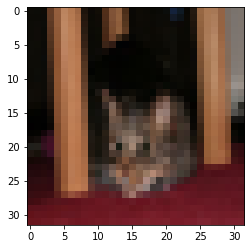

In [ ]:
cfds = CIFAR10Dataset()
print(f"Number of data items: {len(cfds)}")

print(cfds[0][1:])
plt.imshow(cfds[0][0][:,:,::-1])

# Writing custom transforms

Most of the times, we need to process the data before sending it to the model. There are a lot of reasons to do this including:
 - resizing the image
 - data augmentation (flipping, rotation, crops, etc)
 - converting data to the correct format (`np` array to `torch` tensor)

For this example, we'll horizontally flip the images for augmentation and convert the data to a tensor before training.

We don't need to inherit from a special class to create a transform.
A transform is basically a function that takes in a data sample and returns it.

That is also the restriction: It can only take a single argument (i.e. the data sample).



In [ ]:
# example of a transform that doesn't need any parameters
# Convert ndarrays in sample to Tensors

# normal function
def to_tensor(image):
    image = image.copy().astype("float32")
    # swap color axis because
    # numpy image: H x W x C
    # torch image: C x H x W
    # also, shift the image to 0-1 instead of 0-255
    image = image.transpose((2, 0, 1)) / 255
    return torch.from_numpy(image)

# example
print("to_tensor")
print(to_tensor(cfds[0][0]).size())

# callable class
class ToTensor:
    def __call__(self, image):
        image = image.copy().astype("float32")
        # swap color axis because
        # numpy image: H x W x C
        # torch image: C x H x W
        image = image.transpose((2, 0, 1)) / 255
        return torch.from_numpy(image)

# create an object
tensor_transform = ToTensor()
print("ToTensor")
# the object is callable
print(tensor_transform(cfds[0][0]).size())

to_tensor
torch.Size([3, 32, 32])
ToTensor
torch.Size([3, 32, 32])


For writing transforms that need an argument, we have a few different ways around it:
 - currying functions
 - callable classes

flip


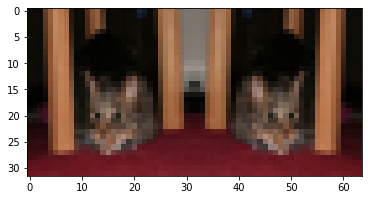

Flip


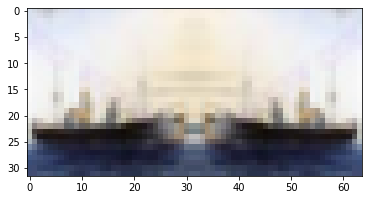

In [ ]:
# transform for flipping

def flip(horizontal=False, vertical=False):

    # this is actually the function that will become the transform
    def _flip(image):
        image = image.copy()
        if horizontal:
            image = np.fliplr(image)
        if vertical:
            image = np.flipud(image)

        return image

    # the outer function returns this function
    return _flip

# example call
print("flip")
orig = cfds[0][0]
flipped = flip(horizontal=True, vertical=False)(cfds[0][0])
plt.imshow(np.hstack([orig, flipped])[:,:,::-1])
plt.show()

class Flip:
    def __init__(self, horizontal=False, vertical=False):
        self.horizontal = horizontal
        self.vertical = vertical
    
    def __call__(self, image):
        image = image.copy()
        if self.horizontal:
            image = np.fliplr(image)
        if self.vertical:
            image = np.flipud(image)

        return image

# example call
print("Flip")
orig = cfds[1][0]
flipped = Flip(horizontal=True, vertical=False)(cfds[1][0])
plt.imshow(np.hstack([orig, flipped])[:,:,::-1])
plt.show()

Most of the transformations are already implemented in `torch`.
A very important one is `transforms.Compose`

It simply takes a list of transforms and applies them in order

# Training a model

Now, we'll train a `torch` model that uses this dataset. For augmentation, we'll be doing horizontal flips.

For flowing the dataset through our model, while we can use a simple `for` loop, it won't have a lot of features like:
 - Batching the data
 - Shuffling the data
 - Load the data in parallel using `multiprocessing` workers

`torch.utils.data.DataLoader` is an iterator which provides all these features.

In [ ]:
# @title Hyperparams {"run": "auto"}
n_epochs = 100# @param {"type":"integer"}
batch_size = 1024# @param {"type":"integer"}
learning_rate = 1e-3# @param {"type": "number"}

loss_fn = nn.CrossEntropyLoss()
optim_fn = optim.Adam

device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
class CIFAR10Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(in_features=3072, out_features=1024),
            nn.ReLU(),
            nn.Linear(in_features=1024, out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=32),
            nn.ReLU(),
            nn.Linear(in_features=32, out_features=10),
        )

    def forward(self, x):
        return self.layers(x)

In [ ]:
def train(model, train_loader, n_epochs, lr, criterion, optim_fn, device):
    model = model.to(device)
    optimizer = optim_fn(model.parameters(), lr)
    loss_history = []

    with tqdm(range(n_epochs)) as prog_bar:
        for epoch in prog_bar:
            epoch_loss = 0
    
            # we are ignoring the labels
            for images, labels_numeric, _ in train_loader:
                # move to correct device and flatten the image
                x = images.to(device).view(images.size(0), -1)
                y = labels_numeric.to(device)
                optimizer.zero_grad()
    
                # the prediction
                out = model(x)
    
                loss = criterion(out, y)
                loss.backward()
                optimizer.step()
    
                epoch_loss += loss
            
            epoch_loss /= len(train_loader)
            prog_bar.set_description(f"loss: {epoch_loss}")
            loss_history.append(epoch_loss.detach())
    
    return loss_history

In [ ]:
cifar10_ds = CIFAR10Dataset(transforms=transforms.Compose([
    # horizontal flip
    # Note that this is not actually an augmentation since __all__ the images
    #   are being flipped.
    #
    # Excercise: modify `Flip` to accept a probability for flipping at random
    Flip(horizontal=True),
    ToTensor(),
]))

train_dl = DataLoader(cifar10_ds, batch_size=batch_size, shuffle=True, num_workers=2)

model = CIFAR10Model()

In [ ]:
loss_history = train(model, train_dl, n_epochs, learning_rate, loss_fn, optim_fn, device)

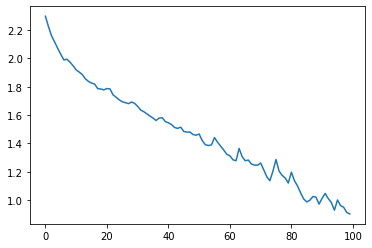

In [ ]:
plt.plot(loss_history)

# Excercises
Modify the `Flip` transform to accept a probability for flipping the image randomly.

# References
 - https://pytorch.org/tutorials/beginner/data_loading_tutorial.html
 - https://www.cs.toronto.edu/~kriz/cifar.html